### Imports and configuration

In [1]:
import pandas as pd
import numpy as np
from os.path import join as opj
from collections import defaultdict, Counter

import sys
sys.path.append('/home/isabrah/sustainability_wikipedia/sustainable-high-quality-wikis')
from modeling.modeling_utils import find_optimal_threshold, eval_classification_preds
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, average_precision_score
from sklearn.impute import SimpleImputer
import statsmodels.api as sm
import shap
import seaborn as sns
import matplotlib.pyplot as plt
import json
from copy import deepcopy
from tqdm import tqdm

### Analysis #1 - predicting the newest promoted pages. Those that the model does not rely on while modeling

In [19]:
model_version = 10.2 # 20.2 #use 10.2 for FA and 20.2 for GA 
target_column = 'is_sustainable_conservative_approach'#'is_sustained'
model_folder = '/shared/3/projects/relationship-aware-networks-wikipedia/models'

In [20]:
# loading the json file of the model (configurations)
model_params_f_name = opj(model_folder, str(model_version), 'model_params.json')
with open(model_params_f_name, 'r', encoding='utf-8') as infile:
    model_info_dict = json.load(infile)
    infile.close()
usecase = model_info_dict['usecase']
seed = int(model_info_dict['seed'])
folds_k = int(model_info_dict['folds_k'])
max_year_to_include = int(model_info_dict['max_year_to_include'])
until_promotion = model_info_dict['until_promotion']
max_revisions_to_use = model_info_dict['max_revisions_to_use']
classification_model = deepcopy(eval(model_info_dict['classification_model']))

In [21]:
# loading the data for modeling
data_df = pd.read_csv(opj(model_folder, str(model_version), 'modeling_df.csv'))
# Set the first column as the index
data_df.set_index(data_df.columns[0], inplace=True)
data_df[target_column] = data_df[target_column].astype(int)
# filtering too new articles
if max_year_to_include is not None:
    train_df = data_df[data_df['TIME_promotion_year'] <= max_year_to_include].copy()
    eval_df = data_df[data_df['TIME_promotion_year'] > max_year_to_include].copy()
    print(f"Max year filter has been applied over the TRAIN dataset. Filtered dataset shape: {train_df.shape}.", flush=True)
# all features that start with 'TIME_' should not be included in the modeling df
x_columns = [c for c in train_df.columns if c != target_column and not c.startswith('TIME_')]

Max year filter has been applied over the TRAIN dataset. Filtered dataset shape: (5814, 331).


In [30]:
existing_columns = [c.replace('_', '-') for c in x_columns]
feature_set = [c.split('-')[0] for c in existing_columns]
feature_name = ['-'.join(c.split('-')[1:]) if not c.startswith('TOPIC') else '-'.join(c.split('-')[2:]) for c in existing_columns]

In [6]:
x_train_data = train_df[x_columns].copy()
y_train_data = train_df[target_column]
x_eval_data = eval_df[x_columns].copy()
y_eval_data = eval_df[target_column]

# filling up the missing values
# filling the missing values with the mean
imputer = SimpleImputer(strategy='mean')

# Fit the imputer on the training data and transform both train and test sets
x_train_imputed = pd.DataFrame(imputer.fit_transform(x_train_data), columns=x_train_data.columns).copy()
x_eval_imputed = pd.DataFrame(imputer.transform(x_eval_data), columns=x_eval_data.columns).copy()
# load the data again to make sure it is a fresh new one and not already trained
classification_model = deepcopy(eval(model_info_dict['classification_model']))
classification_model.fit(x_train_imputed, list(y_train_data))

GradientBoostingClassifier()

In [7]:
y_eval_pred_proba = classification_model.predict_proba(x_eval_imputed)[:, 1]
eval_df['pred'] = y_eval_pred_proba
eval_df.sort_values(by='pred', inplace=True, ascending=True)
top_x_to_take = 1651 if usecase=='ga' else 140 #5%
top_x_predicted_unsustained = eval_df.iloc[0:top_x_to_take][['TIME_promotion_date', 'TIME_demotion_date', target_column, 'pred']].copy()

In [8]:
1 - sum(top_x_predicted_unsustained[target_column]) / top_x_to_take

0.014285714285714235

In [11]:
top_x_predicted_unsustained

,TIME_promotion_date,TIME_demotion_date,is_sustainable_conservative_approach,pred
Unnamed: 0,,,,
45051683,2019-11-13 00:00:00,NaN,1,0.531254
67512396,2022-10-11 00:00:00,NaN,1,0.537335
28222625,2020-05-24 00:00:00,NaN,1,0.547243
55728902,2021-03-20 00:00:00,NaN,1,0.574877
54611700,2020-11-27 00:00:00,NaN,1,0.584372
...,...,...,...,...
71003165,2022-12-26 00:00:00,NaN,1,0.938003
28269,2023-05-07 00:00:00,NaN,1,0.938154
61608937,2020-10-23 00:00:00,NaN,1,0.938333


In [10]:
top_x_predicted_unsustained[top_x_predicted_unsustained[target_column]==0]

,TIME_promotion_date,TIME_demotion_date,is_sustainable_conservative_approach,pred
Unnamed: 0,,,,
59602196,2019-10-12 00:00:00,2023-12-30 00:00:00,0,0.886981
18621887,2021-03-27 00:00:00,2022-02-26 23:17:50,0,0.892377


In [30]:
# I have seen two main issues that might cause the wired things we see. I am going to handle those two.
# first issue - no demotion date, but sustained=0
demotion_and_label_aligned = [False if demotion_is_na and gold_label==0 else True for demotion_is_na, gold_label in zip(data_df['TIME_demotion_date'].isna(), data_df[target_column])]
Counter(demotion_and_label_aligned)

Counter({True: 7669, False: 102})

In [31]:
# second issue - time in promotion does not make sense (too short)
promotion_column = pd.to_datetime(data_df['TIME_promotion_date'])
demotion_column = pd.to_datetime(data_df['TIME_demotion_date'])
# Calculate the difference in days
time_in_promotion = (demotion_column - promotion_column).dt.days
reasonable_time_in_promotion = [False if t <= 30 else True for t in time_in_promotion]
Counter(reasonable_time_in_promotion)

Counter({True: 7681, False: 90})

In [41]:
# now we'll have to get rid of both... this will be implemented in the production code!
mask1 = pd.Series(reasonable_time_in_promotion, index=data_df.index)
mask2 = pd.Series(demotion_and_label_aligned, index=data_df.index)
# Combine the masks using bitwise AND (&) or OR (|) depending on your filtering logic
combined_mask = mask1 & mask2  # Use | if you want to keep rows where either condition is True

# Apply the mask to the DataFrame
data_df_clean = data_df[combined_mask].copy()

(7579, 332)

### Analysis #2 - error analysis (where the model is False positive or False negative)

In [175]:
model_version = 10.2 # 20.2 #use 10.2 for FA and 20.2 for GA 
# BE CAREFUL HERE!
usecase = 'fa' if model_version==10.2 else 'ga'
target_column = 'is_sustainable_conservative_approach'#'is_sustained'
model_folder = '/shared/3/projects/relationship-aware-networks-wikipedia/models'
data_folder = '/shared/3/projects/relationship-aware-networks-wikipedia/wiki_generated_data/'
metadata_files_folder = opj(data_folder, 'meta_data')

In [176]:
modeling_df = pd.read_csv(opj(model_folder, str(model_version), 'modeling_df.csv'))
row_lvl_preds = pd.read_csv(opj(model_folder, str(model_version), 'row_lvl_preds.csv'))
# Set the first column as the index
modeling_df.set_index(modeling_df.columns[0], inplace=True)
row_lvl_preds.set_index(row_lvl_preds.columns[0], inplace=True)
row_lvl_preds.columns = ['pred']

In [177]:
modeling_df_concise = modeling_df[[target_column, 'TIME_promotion_date']]
# merge the two
merged_dfs = pd.merge(modeling_df_concise, row_lvl_preds, left_index=True, right_index=True, how='inner')
merged_dfs.rename_axis("page_id", axis="index", inplace=True)
merged_dfs.sort_values(by='pred',inplace=True)

In [178]:
# extract the top X false negative (dynamic)
top_x = 50
top_x_false_negative = merged_dfs[merged_dfs[target_column]==False][0:top_x].copy()
top_x_page_ids = list(top_x_false_negative.index)

In [179]:
# now, we're analyzing these specific X pages, to see how many reviews they have been gone through
# load the data to analyze this king of data
events_df = pd.read_csv(opj(metadata_files_folder, 'article_events_from_latest_talkpages.csv'))
if usecase == 'fa':
    false_negative_review_events = events_df[(events_df['page_id'].isin(set(top_x_page_ids))) & (events_df['action'].isin({'far'}))].copy()
    all_population_review_events = events_df[events_df['action'].isin({'far'})].copy()
    demoted_pages = events_df[(events_df['action'].isin({'far'})) & (events_df['result'].isin({'demoted', 'fail'}))]['page_id']
    all_demoted_review_events = events_df[(events_df['action'].isin({'far'})) & (events_df['page_id'].isin(demoted_pages))]
    all_population_promotion_events = events_df[(events_df['action'].isin({'fac'})) & (events_df['result'].isin({'promoted'}))]
    
elif usecase == 'ga':
    false_negative_review_events = events_df[(events_df['page_id'].isin(set(top_x_page_ids))) & (events_df['action'].isin({'gar'}))].copy()
    all_population_review_events = events_df[events_df['action'].isin({'gar'})].copy()
    demoted_pages = events_df[(events_df['action'].isin({'gar'})) & (events_df['result'].isin({'delisted', 'fail'}))]['page_id']
    # the GA is special, a page can go through GA and then FA and then demoted
    demoted_pages2 = events_df[(events_df['action'].isin({'far'})) & (events_df['result'].isin({'demoted', 'fail'}))]['page_id']
    demoted_pages = list(demoted_pages) + list(demoted_pages2)
    all_demoted_review_events = events_df[(events_df['action'].isin({'gar'})) & (events_df['page_id'].isin(demoted_pages))]
    all_population_promotion_events = events_df[(events_df['action'].isin({'gan'})) & (events_df['result'].isin({'listed'}))]

#### Barplot of the distribution

In [180]:
# we will create a dataframe for each case
false_negatives_dict_for_plot = dict()
for p_id in top_x_page_ids:
    was_reviewed = True if p_id in false_negative_review_events['page_id'] else False
    num_reviews = false_negative_review_events[false_negative_review_events['page_id'] == p_id].shape[0]
    false_negatives_dict_for_plot[p_id] = {'was_reviewed': was_reviewed, 'num_reviews': num_reviews}

all_population_dict_for_plot = dict()
for p_id in set(all_population_promotion_events['page_id']):
    was_reviewed = True if p_id in set(all_population_review_events['page_id']) else False
    num_reviews = all_population_review_events[all_population_review_events['page_id'] == p_id].shape[0]
    all_population_dict_for_plot[p_id] = {'was_reviewed': was_reviewed, 'num_reviews': num_reviews}

demoted_population_dict_for_plot = dict()
for p_id in set(demoted_pages):
    was_reviewed = True if p_id in set(all_demoted_review_events['page_id']) else False
    num_reviews = all_demoted_review_events[all_demoted_review_events['page_id'] == p_id].shape[0]
    demoted_population_dict_for_plot[p_id] = {'was_reviewed': was_reviewed, 'num_reviews': num_reviews}

In [181]:
demoted_population_df_for_plot = pd.DataFrame.from_dict(demoted_population_dict_for_plot, orient='index')
demoted_population_df_for_plot['group'] = 'Unsustainable'
false_negatives_df_for_plot = pd.DataFrame.from_dict(false_negatives_dict_for_plot, orient='index')
false_negatives_df_for_plot['group'] = 'Suspected Unsustainable'
all_population_df_for_plot = pd.DataFrame.from_dict(all_population_dict_for_plot, orient='index')
all_population_df_for_plot['group'] = 'All Population'

In [182]:
# Combine the two DataFrames
combined_df = pd.concat([demoted_population_df_for_plot, false_negatives_df_for_plot, all_population_df_for_plot])
combined_df.head()

,was_reviewed,num_reviews,group
4456451,True,1,Unsustainable
2465797,True,1,Unsustainable
980998,True,1,Unsustainable
210952,True,1,Unsustainable
86025,True,1,Unsustainable


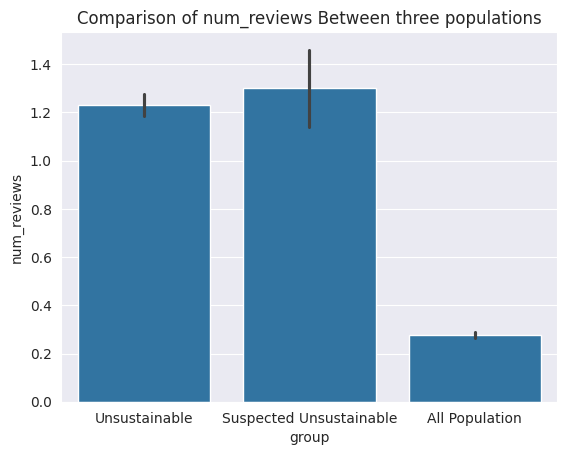

In [183]:
column_tp_plot = 'num_reviews' #was_reviewed' #num_reviews'
# Plot using seaborn
sns.barplot(x='group', y=column_tp_plot, data=combined_df, errorbar="ci")

# Add labels and title
plt.ylabel(column_tp_plot)
plt.title(f'Comparison of {column_tp_plot} Between three populations')

# Show the plot
plt.show()

In [58]:
sns.barplot(pd.DataFrame.from_dict({'Suspected Unsustainable': list(false_negatives_df_for_plot['was_reviewed']),
                          'All Promoted': list(all_population_df_for_plot['was_reviewed'])}), errorbar=("ci"))

ValueError: All arrays must be of the same length

In [51]:
false_negative_review_events.shape

(56, 6)

In [52]:
all_population_review_events.shape

(4622, 6)

In [53]:
all_population_articles_promoted

39196

### Analysis #3: Regression coefficients

In [18]:
model_version = 10.2#10.02#1.99 #1.2
target_column = 'is_sustainable_conservative_approach'#'is_sustained'
model_folder = '/shared/3/projects/relationship-aware-networks-wikipedia/models'
seed = 1984
classification_model = LogisticRegression()

In [19]:
# loading the json file of the model (configurations)
model_params_f_name = opj(model_folder, str(model_version), 'model_params.json')
with open(model_params_f_name, 'r', encoding='utf-8') as infile:
    model_info_dict = json.load(infile)
    infile.close()
usecase = model_info_dict['usecase']
max_year_to_include = int(model_info_dict['max_year_to_include'])
until_promotion = model_info_dict['until_promotion']

In [43]:
# loading the data for modeling
data_df = pd.read_csv(opj(model_folder, str(model_version), 'modeling_df.csv'))
# Set the first column as the index
data_df.set_index(data_df.columns[0], inplace=True)
data_df[target_column] = data_df[target_column].astype(int)
# filtering too new articles
if max_year_to_include is not None:
    train_df = data_df[data_df['TIME_promotion_year'] <= max_year_to_include].copy()
    print(f"Max year filter has been applied over the TRAIN dataset. Filtered dataset shape: {train_df.shape}.", flush=True)
# all features that start with 'TIME_' should not be included in the modeling df
x_columns = [c for c in train_df.columns if c != target_column and not c.startswith('TIME_')]

Max year filter has been applied over the TRAIN dataset. Filtered dataset shape: (5814, 331).


In [44]:
# filling up the missing values
# filling the missing values with the mean
imputer = SimpleImputer(strategy='mean')

x_train_data = train_df[x_columns].copy()
y_train_data = train_df[target_column].copy()

# Fit the imputer on the training data and transform both train and test sets
x_train_imputed = pd.DataFrame(imputer.fit_transform(x_train_data), columns=x_train_data.columns).copy()

In [45]:
reg_res = dict()
# looping over each column and extracting the relevant info
for c in tqdm(x_columns):
    # Create the model
    model = LogisticRegression()
    feature_to_use = c
    
    # Train the model
    model.fit(x_train_imputed[[feature_to_use]], y_train_data)
    
    # Add a constant to the features (intercept term)
    X_train_const = sm.add_constant(x_train_imputed[[feature_to_use]])
    
    # Fit the logistic regression model using statsmodels
    try:
        logit_model = sm.Logit(y_train_data, X_train_const.astype(float))
        result = logit_model.fit(maxiter=100, warn_convergence=False)
    except Exception as e:
        continue
    coef_pvalues = result.summary().tables[1]  # Get the second table from the summary (index 1)
    coef_pvalues_df = pd.DataFrame(coef_pvalues.data[1:], columns=coef_pvalues.data[0])
    cur_p_value = float(coef_pvalues_df.iloc[1]['P>|z|'])
    cur_coef = float(coef_pvalues_df.iloc[1]['coef'])
    reg_res[feature_to_use] = {'coef': cur_coef, 'p_value': cur_p_value}
reg_res_df = pd.DataFrame.from_dict(reg_res, orient='index')

100%|██████████| 326/326 [00:02<00:00, 137.95it/s]


In [46]:
reg_res_df
#reg_res_df[(reg_res_df.index.str.startswith('topic')) & (reg_res_df['p_value'] < 0.01)]

""


### Doing the same, this time with all features we have in hand

In [96]:
# The following features have been removed since they did not allow the reg to converge
#'TOPIC_119_kent', 'TOPIC_120_soviet_union'
x_columns_for_now = x_columns[0:210] + x_columns[323:]
x_columns_for_now = [c for c in x_columns_for_now if c not in {'TOPIC_119_kent', 'TOPIC_120_soviet_union', 'TOPIC_121_disability', 'TOPIC_122_plants', 'TOPIC_123_ice_hockey'}]
x_data = data_df[x_columns_for_now]
# fill in missing values
x_data = x_data.fillna(x_data.mean())
y_data = data_df[target_column]
strat_split = StratifiedShuffleSplit(n_splits=1, test_size=0.001, random_state=seed)

# Generate train/test indices
train_index, test_index = next(strat_split.split(x_data, y_data))

# Create the train/test splits
X_train, X_test = x_data.iloc[train_index], x_data.iloc[test_index]
y_train, y_test = y_data.iloc[train_index], y_data.iloc[test_index]

In [97]:
# Create the model
model = LogisticRegression()
feature_to_use = x_columns

# Train the model
model.fit(X_train, y_train)

# Add a constant to the features (intercept term)
X_train_const = sm.add_constant(X_train)

# Fit the logistic regression model using statsmodels
logit_model = sm.Logit(y_train, X_train_const.astype(float))
result = logit_model.fit(maxiter=300, warn_convergence=False)

/opt/anaconda/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


         Current function value: 0.240295
         Iterations: 300


In [103]:
#result.summary()

In [102]:
# printing only the significant features
# Set the significance level (e.g., 0.05)
significance_level = 0.01

# Get the summary table as a DataFrame
summary_table = result.summary2().tables[1]

# Filter the rows where p-value is less than the significance level
significant_summary_table = summary_table[summary_table['P>|z|'] < significance_level].copy()

# Print the summary table only for significant features
display(significant_summary_table)

,Coef.,Std.Err.,z,P>|z|,[0.025,0.975]
EDIT_num_revisions_normalized,-0.000497,0.000099,-5.012461,5.373838e-07,-0.000691,-0.000302
EDIT_time_to_promotion,0.000863,0.000089,9.711892,2.683090e-22,0.000689,0.001037
SPECIAL_used_to_be_good_article,0.290383,0.076684,3.786760,1.526247e-04,0.140086,0.440681
NETWORK_closeness_stdev,-8.812366,2.183326,-4.036212,5.432114e-05,-13.091607,-4.533126
NETWORK_in_deg_stdev,0.514723,0.195727,2.629801,8.543483e-03,0.131105,0.898341
EDIT_reverts_perc,3.791617,1.237756,3.063300,2.189108e-03,1.365660,6.217574
DISCUSSIONS_num_discussions,-0.024261,0.007844,-3.092950,1.981777e-03,-0.039636,-0.008887
CREDIBILITY_unweighted_score,-5.202308,0.799759,-6.504845,7.777355e-11,-6.769807,-3.634809
EXPERIENCE_unweighted_score,5.705873,0.763548,7.472845,7.847929e-14,4.209348,7.202399
TOPIC_7_video_games,0.343229,0.091148,3.765638,1.661244e-04,0.164583,0.521875


## CV Process

In [85]:
model_version = 2.2#20.02
use_only_meta_features = False
target_column = 'is_sustained'
model_folder = '/shared/3/projects/relationship-aware-networks-wikipedia/models'
seed = 1984
folds_k = 5
classification_model = RandomForestClassifier()#GradientBoostingClassifier(n_estimators=100)

In [86]:
# loading the data for modeling
data_df = pd.read_csv(opj(model_folder, str(model_version), 'modeling_df.csv'))
# loading the json file of the model (configurations)
model_params_f_name = opj(model_folder, str(model_version), 'model_params.json')
with open(model_params_f_name, 'r', encoding='utf-8') as infile:
    model_info_dict = json.load(infile)
    infile.close()
usecase = model_info_dict['usecase']
max_year_to_include = model_info_dict['max_year_to_include']

In [87]:
# Set the first column as the index
data_df.set_index(data_df.columns[0], inplace=True)
data_df[target_column] = data_df[target_column].astype(int)
# filtering too new articles
if max_year_to_include is not None:
    data_df = data_df[data_df['TIME_promotion_year'] <= max_year_to_include].copy()
    print(f"Max year filter has been applied. Filtered dataset shape: {data_df.shape}.", flush=True)

Max year filter has been applied. Filtered dataset shape: (33305, 331).


In [88]:
# all features that start with 'TIME_' should not be included in the modeling df
x_columns = [c for c in data_df.columns if c != target_column and not c.startswith('TIME_')]
# if we want to include specific sets of features (e.g., meta)
if use_only_meta_features:
    x_columns = [c for c in x_columns if c.startswith('META_')]
x_data = data_df[x_columns].copy()
y_data = data_df[target_column].copy()

In [89]:
x_data.shape

(33305, 326)

In [90]:
skf = StratifiedKFold(n_splits=folds_k, shuffle=True, random_state=seed)
eval_measures_train = dict()
eval_measures_test = dict()
predictions = dict()
feature_importance = defaultdict(float)
for cv_index, (train_index, test_index) in enumerate(skf.split(x_data, y_data)):
    x_train, x_test = x_data.iloc[train_index], x_data.iloc[test_index]
    y_train, y_test = y_data.iloc[train_index], y_data.iloc[test_index]
    
    # filling the missing values with the mean
    imputer = SimpleImputer(strategy='mean')

    # Fit the imputer on the training data and transform both train and test sets
    x_train_imputed = pd.DataFrame(imputer.fit_transform(x_train), columns=x_train.columns)
    x_test_imputed = pd.DataFrame(imputer.transform(x_test), columns=x_train.columns)

    model = classification_model
    model.fit(x_train_imputed, y_train)

    # Evaluate the Model
    y_pred = model.predict(x_test_imputed)
    y_pred_proba = model.predict_proba(x_test_imputed)[:, 1]
    
    # finding the optimal threshold
    y_train_pred_proba = model.predict_proba(x_train_imputed)[:, 1]
    macro_optimal_th = find_optimal_threshold(y_true=y_train, predicted_proba=y_train_pred_proba, average='macro')
    binary_optimal_th = find_optimal_threshold(y_true=y_train, predicted_proba=y_train_pred_proba, average='binary')

    # Evaluate the Model
    y_test_pred_proba = model.predict_proba(x_test_imputed)[:, 1]
    y_pred_test = model.predict(x_test_imputed)
    eval_dict_test = eval_classification_preds(true_values=y_test, preds=y_pred_test,
                                               preds_proba=y_test_pred_proba, macro_optimal_th=macro_optimal_th, binary_optimal_th=binary_optimal_th)
    eval_dict_train = eval_classification_preds(true_values=y_train, preds=model.predict(x_train_imputed),
                                                preds_proba=y_train_pred_proba, macro_optimal_th=macro_optimal_th, binary_optimal_th=binary_optimal_th)

    eval_measures_train[cv_index] = eval_dict_train
    eval_measures_test[cv_index] = eval_dict_test
    cur_pred_per_page = {page_id: pred for page_id, pred in zip(y_test.index, y_test_pred_proba)}
    predictions.update(cur_pred_per_page)
    # feature importance process
    cur_feature_importance = {f_name: f_importance for f_name, f_importance in zip(model.feature_names_in_, model.feature_importances_)}
    for cfi, value in cur_feature_importance.items():
        feature_importance[cfi] += value
    print(f"Fold {cv_index} has ended.")

Fold 0 has ended.
Fold 1 has ended.
Fold 2 has ended.
Fold 3 has ended.
Fold 4 has ended.


In [91]:
eval_measures_train_df = pd.DataFrame.from_dict(eval_measures_train, orient='index')
eval_measures_test_df = pd.DataFrame.from_dict(eval_measures_test, orient='index')
# append the average values as a new row to the DataFrame
eval_measures_train_df.loc['mean'] = eval_measures_train_df.mean()
eval_measures_train_df.loc['std'] = eval_measures_train_df.std()
eval_measures_test_df.loc['mean'] = eval_measures_test_df.mean()
eval_measures_test_df.loc['std'] = eval_measures_test_df.std()
#eval_measures_train_df

In [92]:
eval_measures_test_df

,n,accuracy,precision,recall,f1,accuracy_opt_th,precision_opt_th,recall_opt_th,f1_opt_th,auc,ap_score
0,6661.0,0.919682,0.827947,0.608674,0.651191,0.919682,0.827947,0.608674,0.651191,0.845183,0.925161
1,6661.0,0.917580,0.797190,0.613262,0.653911,0.917580,0.797190,0.613262,0.653911,0.844442,0.925975
2,6661.0,0.917280,0.806603,0.601601,0.640760,0.917280,0.782409,0.628903,0.669323,0.825901,0.923911
3,6661.0,0.915028,0.790775,0.591019,0.626272,0.915028,0.790775,0.591019,0.626272,0.821702,0.922047
4,6661.0,0.914577,0.785614,0.592133,0.627318,0.914577,0.785614,0.592133,0.627318,0.820817,0.922116
mean,6661.0,0.916829,0.801626,0.601338,0.639890,0.916829,0.796787,0.606798,0.645603,0.831609,0.923842
std,0.0,0.001856,0.014909,0.008801,0.011563,0.001856,0.016364,0.014128,0.016559,0.010919,0.001581


In [93]:
from scipy.stats import t
t.interval(0.95, 5, loc=0.645, scale=0.0165)  # 95% confidence interval

(0.6025853997120009, 0.6874146002879992)

## Plotting interesting features

The average :: median value of credibility_unweighted_score for sustainable cases is 2.3135218663900683 :: 1.5191599543024463
The average :: median value of credibility_unweighted_score for unsustainable cases is 0.7519725496003946 :: 0.4097353944733181


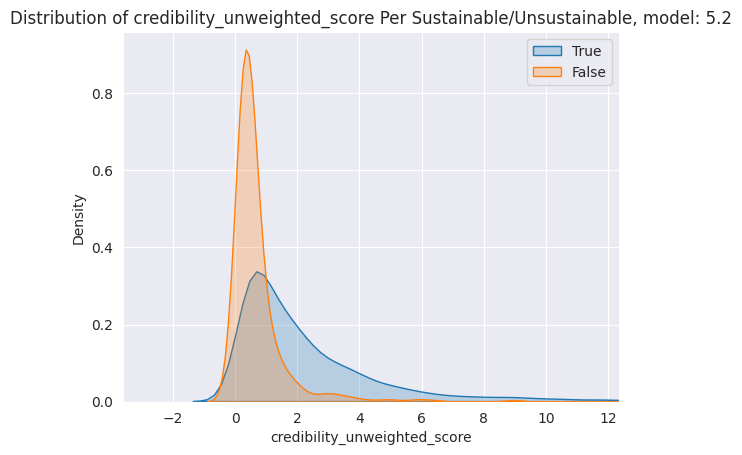

In [40]:
# plotting
feature_to_plot = 'credibility_unweighted_score' #'discussions_sentiment_mean'
feature_mean_sustainable = np.nanmean(data_df[data_df['is_sustained'] == True][feature_to_plot])
feature_mean_unsustainable = np.nanmean(data_df[data_df['is_sustained'] == False][feature_to_plot])
feature_median_sustainable = np.nanmedian(data_df[data_df['is_sustained'] == True][feature_to_plot])
feature_median_unsustainable = np.nanmedian(data_df[data_df['is_sustained'] == False][feature_to_plot])
print(f"The average :: median value of {feature_to_plot} for sustainable cases is {feature_mean_sustainable} :: {feature_median_sustainable}")
print(f"The average :: median value of {feature_to_plot} for unsustainable cases is {feature_mean_unsustainable} :: {feature_median_unsustainable}")
# Distribution for sustainable == True
sns.kdeplot(data_df[data_df['is_sustained'] == True][feature_to_plot], label='True', fill=True)

# Distribution for sustainable == False
sns.kdeplot(data_df[data_df['is_sustained'] == False][feature_to_plot], label='False', fill=True)

# heavy tali handling
quantile_true = data_df[data_df['is_sustained'] == True][feature_to_plot].quantile(0.99)
quantile_false = data_df[data_df['is_sustained'] == False][feature_to_plot].quantile(0.99)
# Determine the maximum x value based on the 0.99 quantile
max_x = max(quantile_true, quantile_false)

plt.title(f'Distribution of {feature_to_plot} Per Sustainable/Unsustainable, model: {model_version}')
plt.xlabel(feature_to_plot)
plt.ylabel('Density')
plt.xlim(right=max_x)
plt.legend()
plt.show()